### 1 模型介绍
此项目采用经典的LSTM编解码器实现机动车的轨迹预测。在该任务中，输入为观测到的车辆历史轨迹信息，输出为预测的未来车辆轨迹。

#### 1.1 模型概述
LSTM Encoder-Decoder是最常见的sequence-to-sequence（seq2seq）模型，最早由2014年的经典论文[《Sequence to Sequence Learning with Neural Networks》](https://arxiv.org/abs/1409.3215)提出，被引量已经过万。该模型的基本思想是用一个RNN网络（编码器）来将输入的序列编码为一个固定长度的向量（context vector），该向量可以被视为整个输入序列的一个抽象表示，然后将该向量作为另一个RNN网络（解码器）的初始输入，并输出任意长度的目标序列。

#### 1.2 模型架构
- Encoder采用了一层全连接层，四层LSTM，并且采用了dropout来降低过拟合；
- Decoder的结构和Encoder的结构基本一致，区别在于Decoder每次接受输入的序列长度只有1，然后每次Decoder的输出都作为下一个时间点的预测。
- 最终的Seq2Seq模型结合了Encoder和Decoder，Encoder将输入的所有历史时间步的轨迹编码为一个context vector，然后将其作为Decoder的初始输入，并将Encoder最终的hidden state和cell state作为Decoder初始的hidden state和cell state，重复使用Decoder来预测下一个时间点的预测，最终输出所有未来时间步的预测轨迹。

#### 1.3 具体实现
- **数据预处理**：主要是从csv格式的数据中提取和整理轨迹信息，这里为了能达到较好训练效果，采用前后时刻的位移矢量而非绝对坐标作为模型输入。
- **训练**：采用了常用的teacher-forcing技巧，即训练的时候Decoder的输入按照一定概率为上一次的输出或者真实的当前时间点的数据，使得网络能够一定程度上避免时序预测的缺陷：初始预测偏离而导致后续结果受到影响。
- **测试/评估**：使用训练好的模型对所有测试数据进行预测，计算出所需的评价指标。为了保证评估结果的客观性，不使用teacher-forcing。
- **可视化**：使用训练好的模型对部分测试数据进行预测，绘制出历史轨迹、真实轨迹和预测轨迹。

### 2 本地部署
- 此项目可以下载至本地进行部署
- 设备要求：Windows/Linux环境下运行，预装Anaconda/Miniconda；
- 若有英伟达的独立显卡且配置好cuda核，默认采用独立显卡进行训练，否则采用cpu进行；
- 单张4070Ti训练500轮大概需要8min，项目中给出了采用gpu训练好的案例模型，即results/model/example_best_seq2seq.pt；若采用cpu运行则速度较慢，运行200轮也可以达到一定效果

#### 2.1 数据集下载和准备
采用的是SinD数据集中提取的部分左转车辆的轨迹片段，数据量较小，代码中的data文件夹已经给出，不需要额外进行下载。

#### 2.2 Python虚拟环境配置

conda create --name PT python=3.7 \
conda activate PT \
 \# 安装pytorch \
 \# 若有显卡，当支持的cuda版本高于11.3时，安装对应pytorch。若无显卡，默认安装cpu版本 \
conda install pytorch==1.10.0 torchvision==0.11.0 torchaudio==0.10.0 cudatoolkit=11.3 -c pytorch \
pip install numpy \
pip install pandas \
pip install matplotlib

### 3 交互式运行

#### 3.0 模块导入和基础函数

In [1]:
# 模块导入
import os
import time
import pickle
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 绝对坐标 → 位移矢量
def diff(array):
    diff_array = np.diff(array, axis=1)
    padded_diff_array = np.concatenate([np.zeros((array.shape[0], 1, array.shape[2])), diff_array], axis=1)
    initial_values = array[:, 0]
    return padded_diff_array, initial_values

# 绝对坐标 ← 位移矢量
def diff_return(padded_diff_array, initial_values):
    restored_array = np.cumsum(padded_diff_array, axis=1) + initial_values[:, np.newaxis, :]
    return restored_array

# 时间计算
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    mins = int(elapsed_time // 60)
    secs = int(elapsed_time % 60)
    return mins, secs


# 定义轨迹数据的类
class CustomDataset:
    def __init__(self, data, labels, initial_values):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.initial_values = torch.tensor(initial_values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], self.initial_values[idx]

#### 3.2 数据预处理

In [3]:
def createSequence(data, hist_len=20, fut_len=30):
    # 对每条轨迹分别切割获得数据和标签
    trajs = []
    for traj_id in set(data['id']):
        data_one_veh = data.loc[data['id'] == traj_id]
        data_one_veh = np.array(data_one_veh.loc[:, ['x', 'y']])
        if data_one_veh.shape[0] <= hist_len + fut_len:
            continue
        window = 2
        for i in range(0, data_one_veh.shape[0] - hist_len - fut_len, window):
            # 过滤掉几乎静止的数据
            if np.linalg.norm(data_one_veh[i] - data_one_veh[i:i + hist_len]) < 1 \
                    or np.linalg.norm(data_one_veh[i:i + hist_len] - data_one_veh[i + hist_len + fut_len]) < 1 \
                    or np.diff(data_one_veh[i:i + hist_len + fut_len], axis=0).max() > 5:
                continue
            trajs.append(data_one_veh[i:i + hist_len + fut_len])
    trajs = np.array(trajs, dtype='float64')
    # 为了能达到较好训练效果，采用前后时刻的位移矢量而非绝对坐标作为模型输入
    padded_diff_array, initial_values = diff(trajs)
    seq, labels = padded_diff_array[:, :20, :], padded_diff_array[:, 20:, :]
    return seq, labels, initial_values

def preprocess(dataset_path='./data', hist_len=20, fut_len=30, output_path='./data/processed_data.pkl'):
    print('————————————数据预处理开始————————————')
    train_data = pd.read_csv(f'./{dataset_path}/left_veh_train.csv')
    test_data = pd.read_csv(f'./{dataset_path}/left_veh_test.csv')
    # 数据分割
    train_seq, train_labels, train_initial_values = createSequence(train_data, hist_len=hist_len, fut_len=fut_len)
    test_seq, test_labels, test_initial_values = createSequence(test_data, hist_len=hist_len, fut_len=fut_len)
    save_data = (train_seq, train_labels, train_initial_values, test_seq, test_labels, test_initial_values)

    with open(output_path, 'wb') as file:
        pickle.dump(save_data, file)
    print('\n————————————数据预处理结束————————————\n')

In [4]:
preprocess(dataset_path='./data', hist_len=20, fut_len=30, output_path='./data/processed_data.pkl')

————————————数据预处理开始————————————

————————————数据预处理结束————————————


#### 3.2 模型定义与训练

##### 3.2.1 模型定义

In [5]:
# Encoder采用了一层全连接层，四层LSTM，并且采用了dropout来降低过拟合；
class Encoder(nn.Module):
    def __init__(self,
                 input_size = 2,
                 embedding_size = 128,
                 hidden_size = 256,
                 n_layers = 4,
                 dropout = 0.5):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.linear = nn.Linear(input_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers,
                           dropout = dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        x: input batch data, size: [sequence len, batch size, feature size]
        for the trajectory data, size(x) is [20, batch size, 2]
        """
        # embedded: [sequence len, batch size, embedding size]
        embedded = self.dropout(F.relu(self.linear(x)))
        output, (hidden, cell) = self.rnn(embedded)
        # hidden = [n layers * n directions, batch size, hidden size]
        # cell = [n layers * n directions, batch size, hidden size]
        # the n direction is 1 since we are not using bidirectional RNNs
        return hidden, cell

# Decoder的结构和Encoder的结构基本一致，区别在于Decoder每次接受输入的序列长度只有1，然后每次Decoder的输出都作为下一个时间点的预测。
class Decoder(nn.Module):
    def __init__(self,
                 output_size=2,
                 embedding_size=128,
                 hidden_size=256,
                 n_layers=4,
                 dropout=0.5):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Linear(output_size, embedding_size)
        self.rnn = nn.LSTM(embedding_size, hidden_size, n_layers, dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden, cell):
        """
        x : input batch data, size(x): [batch size, feature size]
        """
        x = x.unsqueeze(0)
        embedded = self.dropout(F.relu(self.embedding(x)))
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))

        # prediction = [batch size, output size]
        prediction = self.linear(output.squeeze(0))

        return prediction, hidden, cell


# 最终的Seq2Seq模型结合了Encoder和Decoder进行预测
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hidden_size == decoder.hidden_size, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, x, y, teacher_forcing_ratio=0.5):
        """
        x = [observed sequence len, batch size, feature size]
        y = [target sequence len, batch size, feature size]
        """
        batch_size = x.shape[1]
        target_len = y.shape[0]

        outputs = torch.zeros(y.shape).to(self.device)
        hidden, cell = self.encoder(x)
        decoder_input = x[-1, :, :]

        for i in range(target_len):
            # 解码每一个时间步
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[i] = output

            # 决定是否使用teacher forcing
            teacher_forcing = random.random() < teacher_forcing_ratio
            decoder_input = y[i] if teacher_forcing else output

        return outputs

In [6]:
def train_one_epoch(model, dataloader, optimizer, criterion, dev):
    # 进行一轮训练
    model.train()
    epoch_loss = 0
    for i, (x, y, train_ini) in enumerate(dataloader):
        x = x.transpose(0, 1).to(dev)
        y = y.transpose(0, 1).to(dev)
        optimizer.zero_grad()
        y_pred = model(x, y)
        loss = criterion(torch.cumsum(y_pred, dim=0), torch.cumsum(y, dim=0))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

def train(input_path='./data/processed_data.pkl', model='seq2seq', epochs=100, saved_model_path="./results/model/best_seq2seq.pt"):
    print('————————————模型训练开始————————————')
    BATCH_SIZE = 64
    INPUT_DIM = 2
    OUTPUT_DIM = 2
    ENC_EMB_DIM = 128
    DEC_EMB_DIM = 128
    HID_DIM = 256
    N_LAYERS = 4
    ENC_DROPOUT = 0.5
    DEC_DROPOUT = 0.5

    with open(input_path, 'rb') as file:
        train_seq, train_labels, train_initial_values, val_seq, val_labels, val_initial_values = pickle.load(file)
    # 组织数据
    train_dataset = CustomDataset(train_seq, train_labels, train_initial_values)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    # 加载LSTM Encoder-Decoder模型
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
    dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = Seq2Seq(enc, dec, dev).to(dev)

    best_train_loss = float('inf')

    # 若存在已保存的模型可以继续训练
    if os.path.isfile(saved_model_path):
        model.load_state_dict(torch.load(saved_model_path))
        print("successfully load previous best model parameters")

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        start_time = time.time()
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, dev)
        end_time = time.time()
        mins, secs = epoch_time(start_time, end_time)
        print(F'Epoch: {epoch + 1:02} | Time: {mins}m {secs}s')
        print(F'Train Loss: {train_loss:.3f}')
        # 保存模型
        if train_loss < best_train_loss:
            best_train_loss = train_loss
            torch.save(model.state_dict(), saved_model_path)
            print(f"Best epoch:{epoch+1}")
    print('————————————模型训练结束————————————\n')

In [7]:
train(input_path='./data/processed_data.pkl', model='seq2seq', epochs=500, saved_model_path="./results/model/best_seq2seq.pt")

————————————模型训练开始————————————
Epoch: 01 | Time: 0m 1s
Train Loss: 4.746
Best epoch:1
Epoch: 02 | Time: 0m 1s
Train Loss: 0.801
Best epoch:2
Epoch: 03 | Time: 0m 1s
Train Loss: 0.539
Best epoch:3
Epoch: 04 | Time: 0m 1s
Train Loss: 0.436
Best epoch:4
Epoch: 05 | Time: 0m 1s
Train Loss: 0.319
Best epoch:5
Epoch: 06 | Time: 0m 1s
Train Loss: 0.321
Epoch: 07 | Time: 0m 1s
Train Loss: 0.365
Epoch: 08 | Time: 0m 1s
Train Loss: 0.335
Epoch: 09 | Time: 0m 1s
Train Loss: 0.367
Epoch: 10 | Time: 0m 1s
Train Loss: 0.285
Best epoch:10
Epoch: 11 | Time: 0m 1s
Train Loss: 0.221
Best epoch:11
Epoch: 12 | Time: 0m 1s
Train Loss: 0.228
Epoch: 13 | Time: 0m 1s
Train Loss: 0.245
Epoch: 14 | Time: 0m 1s
Train Loss: 0.225
Epoch: 15 | Time: 0m 1s
Train Loss: 0.211
Best epoch:15
Epoch: 16 | Time: 0m 1s
Train Loss: 0.205
Best epoch:16
Epoch: 17 | Time: 0m 1s
Train Loss: 0.181
Best epoch:17
Epoch: 18 | Time: 0m 1s
Train Loss: 0.180
Best epoch:18
Epoch: 19 | Time: 0m 1s
Train Loss: 0.239
Epoch: 20 | Time: 0m 1

#### 3.3 模型评估

In [8]:
# 评价指标计算
def get_metrics(model, dataloader, metrics, dev):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (x, y, val_ini) in enumerate(dataloader):
            x = x.transpose(0, 1).to(dev)
            y = y.transpose(0, 1).to(dev)
            # 不使用teacher-forcing
            y_pred = model(x, y, teacher_forcing_ratio=0)

            x = x.cpu().detach().numpy().transpose(1,0,2)
            y = y.cpu().detach().numpy().transpose(1,0,2)
            y_pred = y_pred.cpu().detach().numpy().transpose(1,0,2)
            val_ini = val_ini.cpu().detach().numpy()

            gt = diff_return(np.concatenate((x,y),axis=1), val_ini)
            pred = diff_return(np.concatenate((x,y_pred),axis=1), val_ini)

            DE = np.linalg.norm(gt[:,20:,:] - pred[:,20:,:], axis=2)
            results = {}
            
            # 指标计算
            if 'ADE' in metrics:
                results['ADE'] = DE.mean()
            if 'FDE' in metrics:
                results['FDE'] = DE[:,-1].mean()
    return results

# 模型评估主函数
def evaluate(input_path='./data/processed_data.pkl', saved_model_path="./results/model/best_seq2seq.pt", metrics=None):
    print('————————————模型评估开始————————————')
    INPUT_DIM = 2
    OUTPUT_DIM = 2
    ENC_EMB_DIM = 128
    DEC_EMB_DIM = 128
    HID_DIM = 256
    N_LAYERS = 4
    ENC_DROPOUT = 0.5
    DEC_DROPOUT = 0.5

    # 加载数据
    with open(input_path, 'rb') as file:
        train_seq, train_labels, train_initial_values, val_seq, val_labels, val_initial_values = pickle.load(file)

    val_dataset = CustomDataset(val_seq, val_labels, val_initial_values)
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

    # 加载模型类
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
    dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = Seq2Seq(enc, dec, dev).to(dev)

    # 加载模型参数
    if os.path.isfile(saved_model_path):
        model.load_state_dict(torch.load(saved_model_path, map_location=torch.device(dev)))
        print("successfully load previous best model parameters")

    # 计算评价指标
    result_nums = 1
    for num in range(result_nums):
        val_loss = get_metrics(model, val_loader, metrics, dev)
        print(val_loss)
    print('————————————模型评估结束————————————\n')

In [9]:
evaluate(input_path='./data/processed_data.pkl', saved_model_path="./results/model/best_seq2seq.pt", metrics=['ADE','FDE'])

————————————模型评估开始————————————
successfully load previous best model parameters
{'ADE': 0.7339827, 'FDE': 2.00366}
————————————模型评估结束————————————


#### 3.4 模型可视化

In [10]:
def vis(model, dataloader, dev, vis_id, fig_save_path):
    # 模型输入历史轨迹，获取预测轨迹并可视化
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, (x, y, val_ini) in enumerate(dataloader):
            x = x.transpose(0, 1).to(dev)
            y = y.transpose(0, 1).to(dev)

            # 不使用teacher-forcing
            y_pred = model(x, y, teacher_forcing_ratio=0)

            x1 = x.cpu().detach().numpy().transpose(1,0,2)
            y1 = y.cpu().detach().numpy().transpose(1,0,2)
            y_pred1 = y_pred.cpu().detach().numpy().transpose(1,0,2)
            val_ini = val_ini.cpu().detach().numpy()

            gt = diff_return(np.concatenate((x1,y1),axis=1), val_ini)
            pred = diff_return(np.concatenate((x1,y_pred1),axis=1), val_ini)

            plt.figure()
            plt.plot(gt[vis_id, :21, 0], gt[vis_id, :21, 1], 'grey', label='hist_traj')
            plt.plot(gt[vis_id, 20:, 0], gt[vis_id, 20:, 1], 'c', label='fut_traj')
            plt.plot(gt[vis_id, -1, 0], gt[vis_id, -1, 1], 'co')
            plt.plot(pred[vis_id, 20:, 0], pred[vis_id, 20:, 1], 'r', label='pred_traj')
            plt.plot(pred[vis_id, -1, 0], pred[vis_id, -1, 1], 'ro')
            plt.axis('equal')
            plt.legend()
            plt.savefig(fig_save_path, dpi=500)
            plt.show()

    return epoch_loss / len(dataloader)

#模型可视化主函数
def visualize(input_path='./data/processed_data.pkl', saved_model_path="./results/model/best_seq2seq.pt", vis_id=119, fig_save_path='./results/fig/119.jpg'):
    print(f'————————————可视化场景id为{vis_id}————————————')
    INPUT_DIM = 2
    OUTPUT_DIM = 2
    ENC_EMB_DIM = 128
    DEC_EMB_DIM = 128
    HID_DIM = 256
    N_LAYERS = 4
    ENC_DROPOUT = 0.5
    DEC_DROPOUT = 0.5

    # 加载数据
    with open(input_path, 'rb') as file:
        train_seq, train_labels, train_initial_values, val_seq, val_labels, val_initial_values = pickle.load(file)

    val_dataset = CustomDataset(val_seq, val_labels, val_initial_values)
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

    # 加载模型类
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
    dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
    dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = Seq2Seq(enc, dec, dev).to(dev)

    # 加载模型参数
    if os.path.isfile(saved_model_path):
        model.load_state_dict(torch.load(saved_model_path, map_location=torch.device(dev)))
        print("successfully load previous best model parameters")

    # 可视化
    vis(model, val_loader, dev, vis_id, fig_save_path)

————————————可视化场景id为119————————————
successfully load previous best model parameters


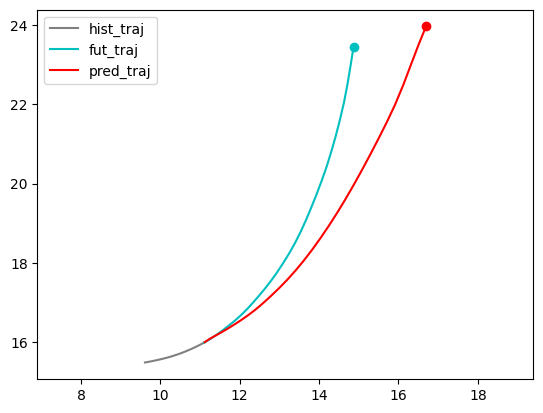

In [11]:
visualize(input_path='./data/processed_data.pkl', saved_model_path="./results/model/example_best_seq2seq.pt", vis_id=119, fig_save_path='./results/fig/119.jpg')